In [1]:
from pathlib import Path
import pickle
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import geopandas as gpd
import pandas as pd
from shapely import wkt

# Special for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
plt.rcParams["font.family"] = "Arial"

from nomad import conf

In [2]:
graph_sn_path = Path().resolve() / 'graph_sn.pkl'
with open(graph_sn_path, 'rb') as inp:
    G_sn = pickle.load(inp)

org_W = G_sn.graph.nodes['org5648002']['pos']
org_H = G_sn.graph.nodes['org5623003']['pos']
dst_CO = G_sn.graph.nodes['dst9822001']['pos']
org_W

(-79.88378970057047, 40.44684367734386)

In [3]:
# Get paths
streets_processed_path = conf.streets_processed_path
nhoods_path = conf.neighborhoods_inpath
study_area_path = conf.study_area_outpath

# Get gdfs: neighborhoods, study area, and streets
# Neighborhoods
nhoods_all = gpd.read_file(nhoods_path)  # all neighbfigsize = get_figsize(2*width, 0.7, 2*width*0.8)orhoods
# Study area
study_area_gdf = gpd.read_file(study_area_path)
# Streets
streets_clip = pd.read_csv(streets_processed_path)
streets_clip['geometry'] = streets_clip['geometry'].apply(wkt.loads)
streets_clip = gpd.GeoDataFrame(streets_clip, crs='epsg:4326')
# Bus stops
GTFS_path = conf.GTFS_path
stops_df = pd.read_csv(GTFS_path + '/stops.txt')
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(x=stops_df['stop_lon'], y=stops_df['stop_lat']), crs='EPSG:4326')
stops_clip = gpd.clip(stops_gdf, study_area_gdf).reset_index()

# Bikeshare
bikeshare_path = conf.bikeshare_station_path
df_bs = pd.read_csv(bikeshare_path)
long_colname, lat_colname = 'Longitude', 'Latitude'
df_bs['geometry'] = gpd.points_from_xy(df_bs[long_colname], df_bs[lat_colname], crs="EPSG:4326")
gdf_bs = gpd.GeoDataFrame(df_bs)  # convert to geo df
bikeshare_clip = gpd.clip(gdf_bs, study_area_gdf).reset_index()

# Bike Lane 
bikemap_folder = conf.bike_map_folder #= os.path.join(cwd, 'Data', 'Input_Data', 'bike-map-2019')
# the WPRDC website provides different GIS files for each bikeway types. here we will concatenate them into one gdf 
# note: we will add trails separately because they are off-road and not included in street centerline file
bikeway_type = ['Bike Lanes', 'On Street Bike Route', 'Protected Bike Lane', 'Bridges', 'Bikeable_Sidewalks', 'Cautionary Bike Route']
gdf_bikeway = gpd.GeoDataFrame()
for b in bikeway_type:
    filename = b + '.shp'
    gdf =  gpd.read_file(bikemap_folder / b / filename)   #(os.path.join(new_path, filename))
    gdf['bikeway_type'] = b
    cols_keep = ['geometry','bikeway_type']
    gdf = gdf[cols_keep]
    gdf_bikeway = pd.concat([gdf_bikeway, gdf])
# clip to the study area (need to change crs)
gdf_bikeway.to_crs(crs=4326, inplace=True) 
gdf_bikeway = gpd.clip(gdf_bikeway, study_area_gdf)
bikelane_keep = ['Bike Lanes', 'Protected Bike Lane', 'Bikeable_Sidewalks']
gdf_bikeway = gdf_bikeway[gdf_bikeway.bikeway_type.isin(bikelane_keep)]
bikeway_namemap = {'Bike Lanes': 'bike lane', 'Protected Bike Lane':'protected bike lane', 'Bikeable_Sidewalks':'bikeable sidewalk'}
gdf_bikeway['bikeway_type'] = gdf_bikeway['bikeway_type'].map(bikeway_namemap)

# Parking meters
park_clip_path = conf.parking_outpath
gdf_park = gpd.read_file(park_clip_path)

# Car share station
carshare_path = conf.carshare_station_path
df_cs = pd.read_csv(carshare_path)
gdf_cs = gpd.GeoDataFrame(data=df_cs, geometry=df_cs['WKT'].apply(wkt.loads), crs='EPSG:4326').reset_index()[['index','geometry']]
gdf_cs_clip = gpd.clip(gdf_cs, study_area_gdf)

prt_path = Path().absolute().parent / 'nomad'/ 'data' / 'network' / 'raw' / 'PRT_Routes' / 'PRT_Routes_current_(2310).shp'
prt_routes = gpd.read_file(prt_path)
prt_routes = gpd.clip(prt_routes, study_area_gdf)


/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [18]:
print("# carshare stations:", len(gdf_cs_clip))
print("# bikeshare stations:", len(bikeshare_clip))
print("# bus stops:", len(stops_clip))
print("# parking meters:", len(pd.read_csv(conf.parking_inpath)))
print("# edges supernetwork:", len(G_sn.graph.edges))
print("# nodes supernetwork:", len(G_sn.graph.nodes))
print("length of streets (km):", round(streets_clip['length_m'].sum()/1000,2))

route_nodes = [n.split('_') for n in G_sn.graph.nodes if n.startswith('rt')]
dir_routes = set([(r[1] + '_' + r[2]) for r in route_nodes])
print("# directional bus routes:", len(dir_routes))

# carshare stations: 10
# bikeshare stations: 20
# bus stops: 1108
# parking meters: 1224
# edges supernetwork: 162669
# nodes supernetwork: 18789
length of streets (km): 640.8
# directional bus routes: 93


/tmp/ipykernel_15719/607940069.py:63: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, _ = ax.get_legend_handles_labels()


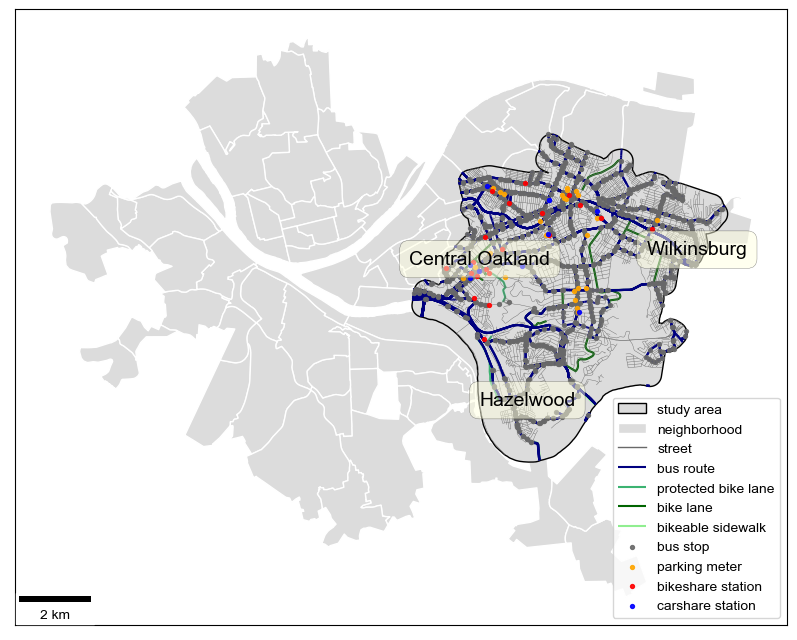

In [40]:
alpha = 0.9
msize = 8

fig,ax = plt.subplots(figsize=(12,8))
nhoods_all.plot(ax=ax, color='gainsboro', edgecolor='white', label='neighborhood') # plot all the neighborhoods
hood_list = conf.neighborhoods 
hood_subset = nhoods_all.loc[nhoods_all['hood'].isin(hood_list)]
#hood_subset.plot(ax=ax) # shade selected neighborhoods

study_area_gdf.plot(ax=ax, color='gainsboro',edgecolor='black', legend=True)
# hood_subset.apply(lambda x: ax.annotate(text=x['hood'], xy=x.geometry.centroid.coords[0], 
#                                         fontsize=6, ha='center'), axis=1)
# od_hoods = nhoods_all.loc[nhoods_all['hood'].isin(['Larimer','Central Oakland'])]
# od_hoods.apply(lambda x: ax.annotate(text=x['hood'], xy=x.geometry.centroid.coords[0], 
#                                         fontsize=14, ha='center'), axis=1)

fontsize=14
bbox = dict(boxstyle='round,pad=0.5', fc='lightyellow', ec='black', lw=0.3, alpha=0.5)
ax.annotate(text='Wilkinsburg', xy=org_W, fontsize=fontsize, bbox=bbox, ha='center')
ax.annotate(text='Hazelwood', xy=org_H, fontsize=fontsize, bbox=bbox, ha='center')
ax.annotate(text='Central Oakland', xy=dst_CO, fontsize=fontsize, bbox=bbox, ha='center')

# Plot lines
streets_clip.plot(ax=ax, color='dimgray', lw=0.3)
prt_routes.plot(ax=ax, color='navy', label='bus route')
# Bikeway
bikeway_cmap = {'bike lane':'darkgreen','protected bike lane':'mediumseagreen', 'bikeable sidewalk':'lightgreen'}
gdf_bikeway['color'] = gdf_bikeway['bikeway_type'].map(bikeway_cmap)
for b in gdf_bikeway['bikeway_type'].unique():
    gdf_bikeway[gdf_bikeway['bikeway_type']==b].plot(ax=ax, color=gdf_bikeway[gdf_bikeway['bikeway_type']==b]['color'], zorder=1, label=b)
# Plot point shapes
stops_clip.plot(ax=ax, color='dimgray', alpha=alpha, markersize=msize, zorder=2, label='bus stop')
gdf_park.plot(ax=ax, color='orange', alpha=alpha, markersize=msize, zorder=2, label='parking meter')
bikeshare_clip.plot(ax=ax, color='red', alpha=alpha, markersize=msize, zorder=2, label='bikeshare station')
gdf_cs_clip.plot(ax=ax, color='blue', alpha=alpha, markersize=msize, zorder=2, label='carshare station')

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

# For the legend
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

pmark1 = mpatches.Patch(facecolor='gainsboro',
                        edgecolor='white',
                        label='neighborhood')
pmark2 = mpatches.Patch(facecolor='gainsboro',
                        edgecolor='black',
                        label='study area')
lmark = mlines.Line2D(
    [],
    [],
    color='dimgray',
    linewidth=1,
    label='street')
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        pmark2, pmark1, lmark, *handles,
        ],
    loc='lower right',
    fontsize=10,
    ncol=1)

# Position and layout
scale1 = ScaleBar(
    dx=distance_meters,
    location="lower left",  # in relation to the whole plot
    font_properties={
        "family": "Arial",
        "size": "10"}
)
ax.add_artist(scale1)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles,labels)

#plt.tight_layout()
#image_dir = '/home/lgraff/Documents/images/'
#plt.savefig(image_dir + 'study_area.png', bbox_inches=None)


/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


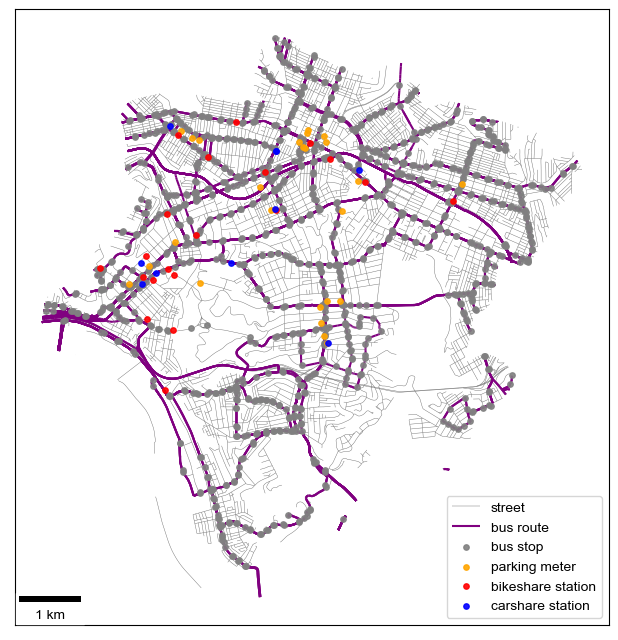

In [16]:
msize = 15
alpha = 0.9
fig,ax = plt.subplots(figsize=(8,8))
# Plot line shapes
streets_clip.plot(ax=ax, color='dimgray', lw=0.3, zorder=0, label='street')
prt_routes.plot(ax=ax, color='purple', label='bus route', zorder=1)
bikeway_cmap = {'Bike Lanes':'darkgreen','Protected Bike Lane':'mediumseagreen', 'Bikeable_Sidewalks':'springgreen'}
gdf_bikeway['color'] = gdf_bikeway['bikeway_type'].map(bikeway_cmap)
for b in gdf_bikeway['bikeway_type'].unique():
    gdf_bikeway[gdf_bikeway['bikeway_type']==b].plot(ax=ax, color=gdf_bikeway[gdf_bikeway['bikeway_type']==b]['color'], zorder=1, label=b)
# Plot point shapes
stops_clip.plot(ax=ax, color='grey', alpha=alpha, markersize=msize, zorder=2, label='bus stop')
gdf_park.plot(ax=ax, color='orange', alpha=alpha, markersize=msize, zorder=2, label='parking meter')
bikeshare_clip.plot(ax=ax, color='red', alpha=alpha, markersize=msize, zorder=2, label='bikeshare station')
gdf_cs_clip.plot(ax=ax, color='blue', alpha=alpha, markersize=msize, zorder=2, label='carshare station')
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
# Add legend
ax.legend(loc='lower right', fontsize=10)
# Add scale
scale2 = ScaleBar(
    dx=distance_meters, location="lower left",  # in relation to the whole plot
    font_properties={
        "family": "Arial",
        "size": "10"})
ax.add_artist(scale2)